# Прогнозирование заказов такси
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Нужно:

- Загрузить данные и выполнить их ресемплирование по одному часу.
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
- Проверить данные на тестовой выборке и сделать выводы.

## Описание данных

`datetime` — дата и время с десятиминутными интервалами

**Целевой признак**: `num_orders` — количество заказов

## Последовательность шагов проекта
1. Загрузка и исследование данных.
2. Подготовка и обучение моделей.
3. Проверка и оценка моделей.
4. Заключение.
## 1. Загрузка и исследование данных.

In [1]:
import pkg_resources

In [2]:
try:
    pkg_resources.get_distribution('prophet')
except pkg_resources.DistributionNotFound:
    !pip3 install prophet

In [3]:
try:
    pkg_resources.get_distribution('catboost')
except pkg_resources.DistributionNotFound:
    !pip install catboost

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

plt.style.use('dark_background')

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
df.index.is_monotonic

True

Ряд монотонно возрастает.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
df.isna().sum()

num_orders    0
dtype: int64

Пропусков в данных нет.

In [10]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


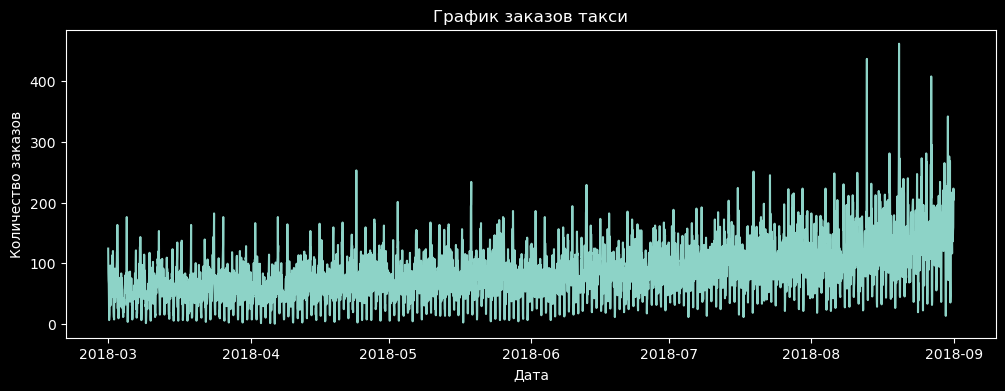

In [11]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df,  legend=None)
plt.title('График заказов такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

На графике заметен тренд на увеличение количества заказов и амплитуды колебаний. Также к концу периода наблюдаются более частые и интенсивные всплески. Временной ряд, скорее всего, является нестационарным. Проверим ряд на стационарность тестом Дики-Фуллера

In [12]:
# Выполняем тест Дики-Фуллера
adf = adfuller(df)

# Распечатываем результаты теста
print('ADF статистика:', adf[0])
print('p-value:', adf[1])
print('Критические значения теста:', adf[4])
if adf[0] > adf[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

ADF статистика: -3.0689242890279482
p-value: 0.028940051402613506
Критические значения теста: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Исходя из результатов теста Дики-Фуллера ряд является стационарным, что позволяет использовать модель авторегрессии-скользящего среднего (ARMA).

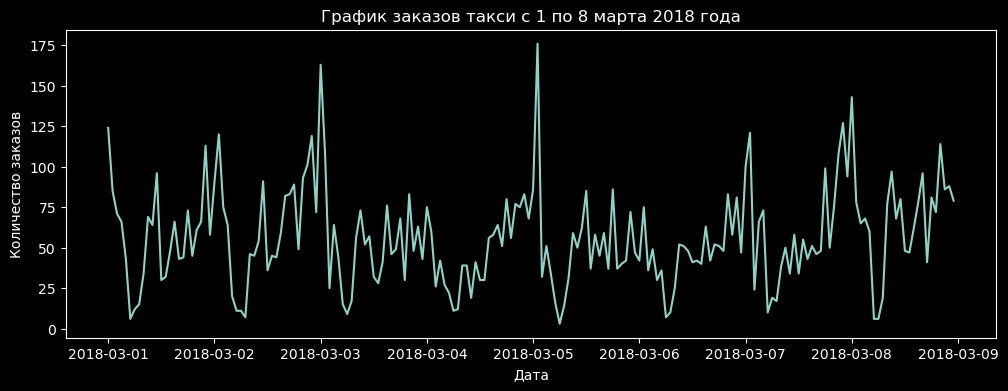

In [13]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df['2018-03-01':'2018-03-08'], legend=None)
plt.title('График заказов такси c 1 по 8 марта 2018 года')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Заметна сезонность ряда. Разложим ряд на тренд, сезонность и шум

In [14]:
decomposed = seasonal_decompose(df)

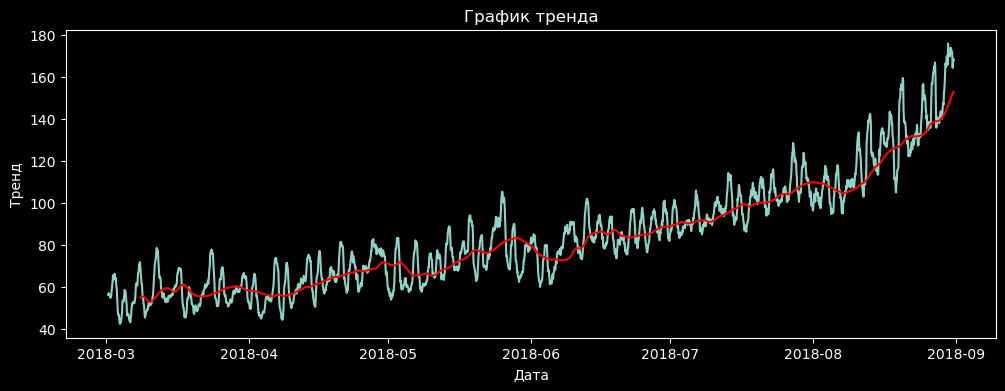

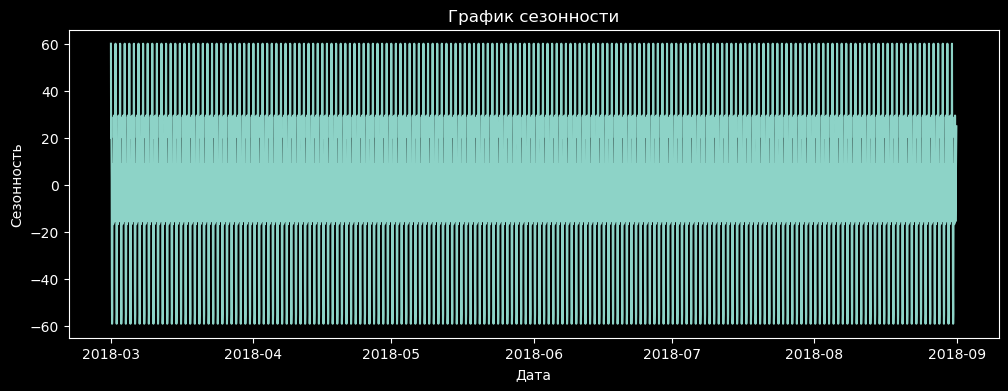

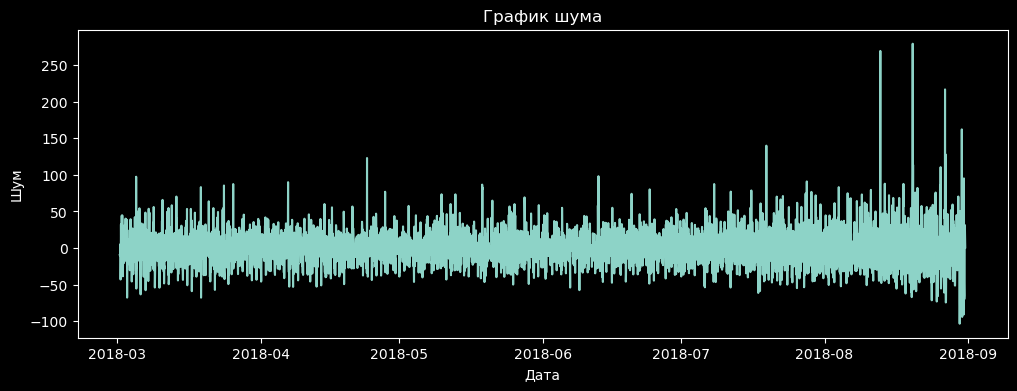

In [15]:
plt.figure(figsize=(12,4))
sns.lineplot(data=decomposed.trend)
sns.lineplot(data=decomposed.trend.rolling(24*7).mean(), color='red')
plt.title('График тренда')
plt.xlabel('Дата')
plt.ylabel('Тренд')
plt.show()
plt.figure(figsize=(12,4))
sns.lineplot(data=decomposed.seasonal)
plt.title('График сезонности')
plt.xlabel('Дата')
plt.ylabel('Сезонность')
plt.show()
plt.figure(figsize=(12,4))
sns.lineplot(data=decomposed.resid)
plt.title('График шума')
plt.xlabel('Дата')
plt.ylabel('Шум')
plt.show()

Декомпозиция временного ряда демонстрирует растущий тренд. Сезонность представляет из себя стационарный ряд. Уровень шума в данных растет к концу рассматриваемого периода.

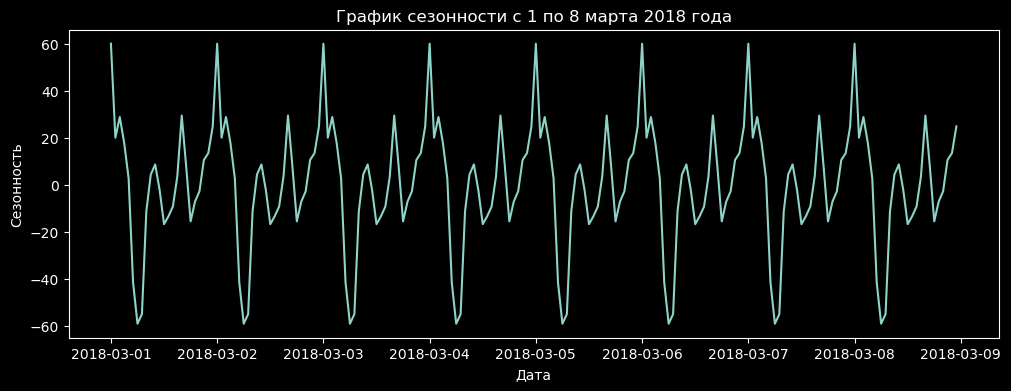

In [16]:
plt.figure(figsize=(12,4))
sns.lineplot(data=decomposed.seasonal['2018-03-01':'2018-03-08'])
plt.title('График сезонности с 1 по 8 марта 2018 года')
plt.xlabel('Дата')
plt.ylabel('Сезонность')
plt.show()

На недельном интервале график сезонности демонстрирует повторяющийся паттерн в суточном диапазоне.

### Вывод
Исходные данные представляют собой монотонно возрастающий временной ряд. Десятиминутные интервалы были преобразованы в часовые с суммированием значений. Пропусков в данных нет. Ряд имеет суточную сезонность. Несмотря на восходящий тренд и увеличение дисперсии к концу рассматриваемого периода, ряд является стационарным согласно тесту Дики-Фуллера. 

## 2. Подготовка и обучение моделей.
Для прогнозирования количества заказов такси проверим модель экспоненциального сглаживания, модель авторегрессии-скользящего среднего, библиотеку Prophet, случайный лес и градиентный бустинг.
Нужно выделить тренировочную и тестовую выборки. Для теста оставим 10% данных.

In [17]:
train, test = train_test_split(df, test_size=0.1, shuffle=False)
train.shape, test.shape

((3974, 1), (442, 1))

### 2.1. Модель экспоненциального сглаживания.
Обучим модель экспоненциального сглаживания из библиотеки statsmodels. Её можно использовать в качестве базовой модели. Тренд и сезонность возьмем линейными, период - 24 часа

In [18]:
exp_smooth = ExponentialSmoothing(train['num_orders'] ,trend='add', seasonal='add', seasonal_periods=24).fit()

### 2.2. SARIMAX.
Обучим модель SARIMAX из библиотеки statsmodels.

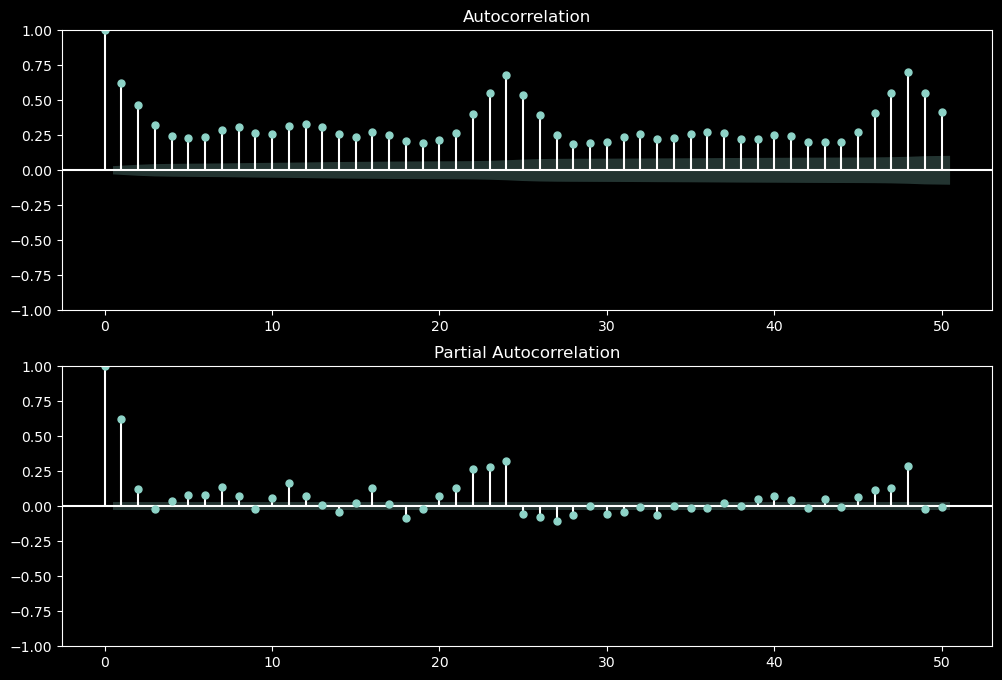

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=50, method='ywm', ax=ax2)

Графики автокорреляции и частичной автокорреляции показывают самые высокие значения на 1, 24 и 48 час.

In [20]:
sarimax = SARIMAX(train['num_orders'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 24)).fit()

### 2.3. Библиотека Prophet
Для использования этой библиотки нужно преобразовать датасет к определенному виду

In [21]:
prophet_train = train.copy()
prophet_test = test.copy()

prophet_train.reset_index(inplace=True)
prophet_test.reset_index(inplace=True)

prophet_train = prophet_train.rename(columns={'datetime': 'ds', 'num_orders': 'y'})
prophet_test = prophet_test.rename(columns={'datetime': 'ds', 'num_orders': 'y'})

In [22]:
prophet_model = Prophet()
prophet_model.fit(prophet_train)

18:29:04 - cmdstanpy - INFO - Chain [1] start processing
18:29:04 - cmdstanpy - INFO - Chain [1] done processing


### 2.4. Случайный лес.
Для использования моделей машинного обучения нужно создать полезные для предсказания признаки. Напишем функцию для создания календарных признаков, отстающих значений и скользящего среднего.

In [23]:
def make_features(data, max_lag, rolling_mean_size):
    # Календарные признаки
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour   
    
    # Отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # Скользящее среднее
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean().shift()

In [24]:
X = df.copy()

make_features(X, 12, 24)

X.dropna(inplace=True)

y = X['num_orders']
X = X.drop('num_orders', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3952, 17), (440, 17), (3952,), (440,))

In [25]:
%%time

rfr = RandomForestRegressor()

rf_space = {'max_depth':list(np.arange(10, 51, step=10)) + [None],
            'n_estimators':np.arange(50, 301, step=50),
            'min_samples_leaf':np.arange(1, 4, step=2)
          }

tscv = TimeSeriesSplit()

rf_random = RandomizedSearchCV(rfr, rf_space, n_iter=13, 
                               scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=2,
                              random_state=13)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Wall time: 32.6 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=13, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, None],
                                        'min_samples_leaf': array([1, 3]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300])},
                   random_state=13, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [26]:
rf_random.best_estimator_, rf_random.best_score_ * -1

(RandomForestRegressor(max_depth=30, min_samples_leaf=3, n_estimators=200),
 24.89372671553601)

### 2.4. Градиентный бустинг.
Используем градиентный бустинг в реализации CatBoost на данных, подготовленных для случайного леса.

In [27]:
catb = CatBoostRegressor()

catb_space = {'depth':list(np.arange(1, 5, step=1)),
              'iterations':np.arange(300, 701, step=50),
               'learning_rate':np.arange(0.01, 0.3, step=0.03),
              'reg_lambda':np.arange(0.01, 0.1, step=0.03)
}

catb_random = RandomizedSearchCV(catb, catb_space, n_iter=30, 
                               scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=2,
                              random_state=13)

catb_random.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0:	learn: 38.0491845	total: 136ms	remaining: 1m 34s
1:	learn: 37.4232796	total: 138ms	remaining: 48.1s
2:	learn: 36.8331323	total: 140ms	remaining: 32.4s
3:	learn: 36.2145354	total: 141ms	remaining: 24.6s
4:	learn: 35.7468470	total: 143ms	remaining: 19.8s
5:	learn: 35.3090364	total: 145ms	remaining: 16.7s
6:	learn: 34.7943642	total: 146ms	remaining: 14.5s
7:	learn: 34.3165330	total: 148ms	remaining: 12.8s
8:	learn: 33.9144641	total: 149ms	remaining: 11.5s
9:	learn: 33.4806412	total: 151ms	remaining: 10.4s
10:	learn: 33.0916008	total: 153ms	remaining: 9.58s
11:	learn: 32.7360637	total: 154ms	remaining: 8.85s
12:	learn: 32.3061343	total: 156ms	remaining: 8.24s
13:	learn: 32.0098573	total: 157ms	remaining: 7.71s
14:	learn: 31.6779567	total: 159ms	remaining: 7.26s
15:	learn: 31.3152509	total: 160ms	remaining: 6.86s
16:	learn: 31.0752270	total: 162ms	remaining: 6.5s
17:	learn: 30.8520795	total: 163ms	remaining: 6.18s
18:	learn: 3

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x000002C35FAEFFA0>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'depth': [1, 2, 3, 4],
                                        'iterations': array([300, 350, 400, 450, 500, 550, 600, 650, 700]),
                                        'learning_rate': array([0.01, 0.04, 0.07, 0.1 , 0.13, 0.16, 0.19, 0.22, 0.25, 0.28]),
                                        'reg_lambda': array([0.01, 0.04, 0.07, 0.1 ])},
                   random_state=13, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [28]:
catb_random.best_estimator_, catb_random.best_score_ * -1

(<catboost.core.CatBoostRegressor at 0x2c363752fd0>, 24.812367713649166)

### Вывод
Мы обучили пять моделей для прогнозирования временного ряда. Посмотрим их значения RMSE на тестовых данных.

# 3. Проверка и оценка моделей.
Испытаем модели на тестовой выборке и сравним их результаты по метрике RMSE.

In [29]:
exp_pred = exp_smooth.forecast(test.shape[0])

In [30]:
mean_squared_error(test, exp_pred) ** 0.5

40.43749205668119

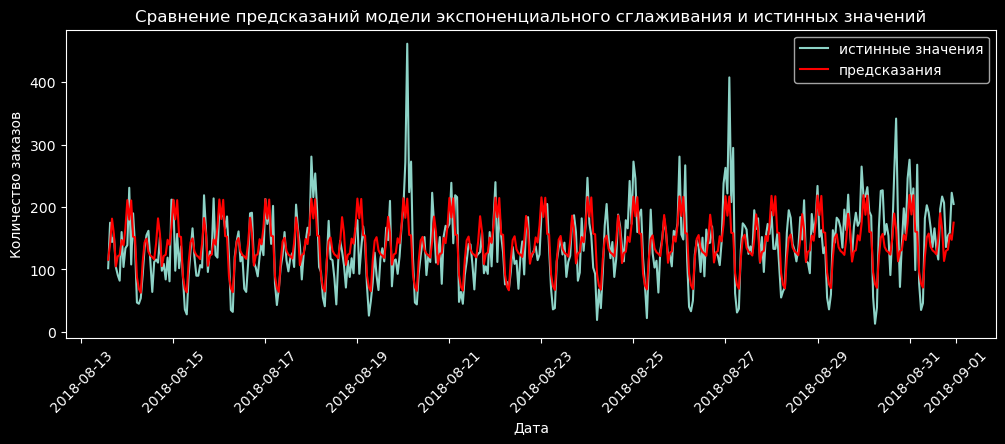

In [31]:
plt.figure(figsize=(12,4))
sns.lineplot(data=test, label='истинные значения', legend=None)
sns.lineplot(data=exp_pred, color='red', label='предсказания')
plt.title('Сравнение предсказаний модели экспоненциального сглаживания и истинных значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.show()

In [32]:
sarimax_pred = sarimax.forecast(test.shape[0])

In [33]:
mean_squared_error(test, sarimax_pred) ** 0.5

50.5518690149596

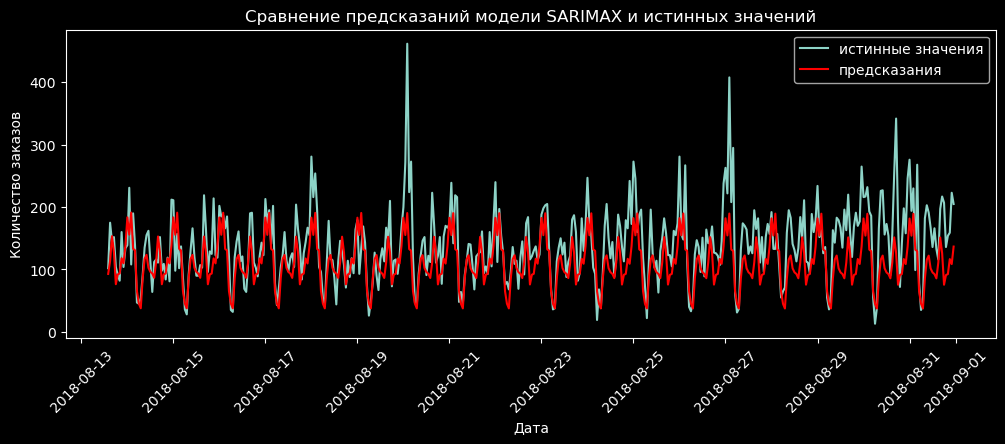

In [34]:
plt.figure(figsize=(12,4))
sns.lineplot(data=test, label='истинные значения', legend=None)
sns.lineplot(data=sarimax_pred, color='red', label='предсказания')
plt.title('Сравнение предсказаний модели SARIMAX и истинных значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.show()

Заметно, что модель SARIMAX не учитывает слабо выраженный восходящий тренд в отличие от модели экспоненциального сглаживания. Вероятно, это связано с тем, что мы приняли ряд за стационарный по результатам теста Дики-Фуллера, хотя в конце ряда заметен тренд и эти данные и находятся в тестовой выборке.

In [35]:
future = prophet_model.make_future_dataframe(periods=test.shape[0], freq='H')

In [36]:
forecast = prophet_model.predict(future)

In [37]:
mean_squared_error(test, forecast.yhat[-test.shape[0]:]) ** 0.5

48.24537848064678

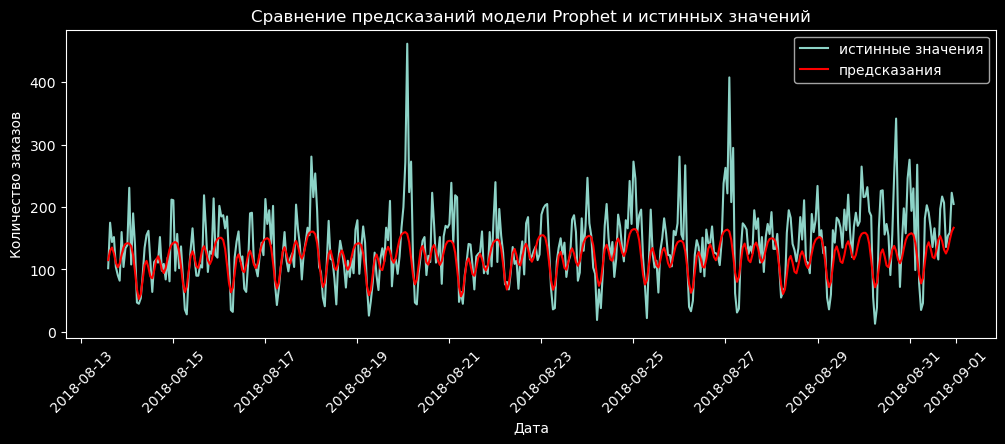

In [38]:
plt.figure(figsize=(12,4))
sns.lineplot(data=test, label='истинные значения', legend=None)
sns.lineplot(data=forecast[-test.shape[0]:], x='ds', y='yhat', color='red', label='предсказания')
plt.title('Сравнение предсказаний модели Prophet и истинных значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.show()

Результаты модели из библиотеки Prophet показывают схожие результаты с моделью SARIMAX, видно что она идет ниже оптимального положения.

In [39]:
rf_pred = pd.Series(rf_random.predict(X_test), index=y_test.index)
mean_squared_error(y_test, rf_pred) ** 0.5

42.9221432170595

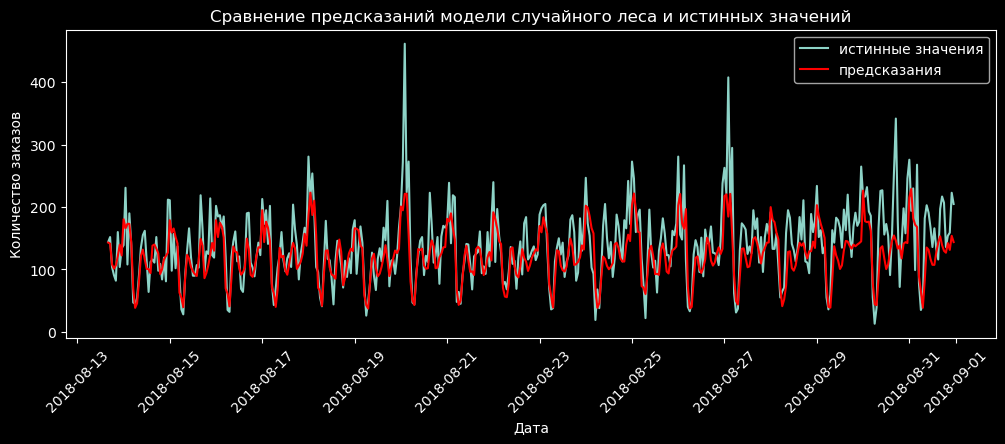

In [40]:
plt.figure(figsize=(12,4))
sns.lineplot(data=y_test, label='истинные значения', legend=None)
sns.lineplot(data=rf_pred, color='red', label='предсказания')
plt.title('Сравнение предсказаний модели случайного леса и истинных значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.show()

In [41]:
catb_pred = pd.Series(catb_random.predict(X_test), index=y_test.index)
mean_squared_error(y_test, catb_pred) ** 0.5

43.49994578909911

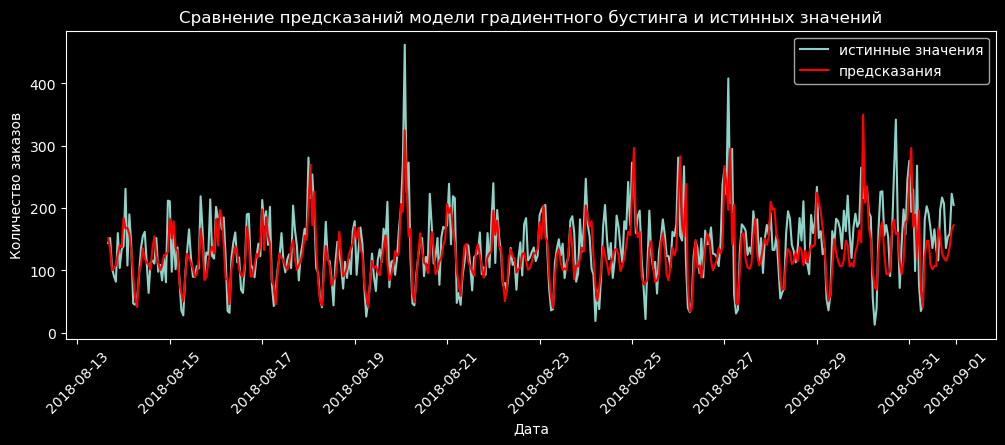

In [42]:
plt.figure(figsize=(12,4))
sns.lineplot(data=y_test, label='истинные значения', legend=None)
sns.lineplot(data=catb_pred, color='red', label='предсказания')
plt.title('Сравнение предсказаний модели градиентного бустинга и истинных значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.show()

Базовая модель экспоненциального сглаживания показала лучшие результаты в прогнозировании количества заказов на тестовой выборке. Можно попробовать совместить модель Prophet и модели случайного леса и градиентного бустинга, чтобы уйти от использования самостоятельно сгенерированных признаков.

In [43]:
prophet_features = forecast.copy()
prophet_features['ds'] = prophet_features['ds'].astype('datetime64')
prophet_features = prophet_features.set_index('ds')
prophet_train, prophet_test = prophet_features[:train.shape[0]], prophet_features[train.shape[0]:]
prophet_train.shape, prophet_test.shape, train.shape, test.shape

((3974, 18), (442, 18), (3974, 1), (442, 1))

In [44]:
prophet_rf_random = RandomizedSearchCV(rfr, rf_space, n_iter=13, 
                               scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=2,
                              random_state=13)

prophet_rf_random.fit(prophet_train, train['num_orders'])

Fitting 5 folds for each of 13 candidates, totalling 65 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=13, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, None],
                                        'min_samples_leaf': array([1, 3]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300])},
                   random_state=13, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [45]:
prophet_rf_random.best_estimator_, prophet_rf_random.best_score_ 

(RandomForestRegressor(max_depth=20, min_samples_leaf=3, n_estimators=150),
 -24.360725980458607)

In [46]:
prophet_catb_random = RandomizedSearchCV(catb, catb_space, n_iter=30, 
                               scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=2,
                              random_state=13)

prophet_catb_random.fit(prophet_train, train['num_orders'])

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0:	learn: 38.4676131	total: 1.2ms	remaining: 719ms
1:	learn: 38.2698925	total: 2.37ms	remaining: 709ms
2:	learn: 38.0694288	total: 3.41ms	remaining: 679ms
3:	learn: 37.8753673	total: 4.45ms	remaining: 664ms
4:	learn: 37.6919179	total: 5.58ms	remaining: 664ms
5:	learn: 37.5040706	total: 6.69ms	remaining: 663ms
6:	learn: 37.3153469	total: 7.73ms	remaining: 655ms
7:	learn: 37.1309939	total: 8.74ms	remaining: 647ms
8:	learn: 36.9573398	total: 9.76ms	remaining: 641ms
9:	learn: 36.7802914	total: 10.8ms	remaining: 636ms
10:	learn: 36.6030902	total: 11.8ms	remaining: 631ms
11:	learn: 36.4332199	total: 12.8ms	remaining: 628ms
12:	learn: 36.2653008	total: 13.7ms	remaining: 621ms
13:	learn: 36.1112374	total: 14.8ms	remaining: 619ms
14:	learn: 35.9671408	total: 15.9ms	remaining: 619ms
15:	learn: 35.8157116	total: 16.8ms	remaining: 615ms
16:	learn: 35.6511382	total: 17.8ms	remaining: 610ms
17:	learn: 35.4884703	total: 18.8ms	remaining: 6

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x000002C35FAEFFA0>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'depth': [1, 2, 3, 4],
                                        'iterations': array([300, 350, 400, 450, 500, 550, 600, 650, 700]),
                                        'learning_rate': array([0.01, 0.04, 0.07, 0.1 , 0.13, 0.16, 0.19, 0.22, 0.25, 0.28]),
                                        'reg_lambda': array([0.01, 0.04, 0.07, 0.1 ])},
                   random_state=13, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [47]:
prophet_catb_random.best_estimator_, prophet_catb_random.best_score_ 

(<catboost.core.CatBoostRegressor at 0x2c3020d83d0>, -24.580126922880787)

In [48]:
prophet_rf_pred = pd.Series(prophet_rf_random.predict(prophet_test), index=test.index)
mean_squared_error(test['num_orders'], prophet_rf_pred) ** 0.5

42.59128456474226

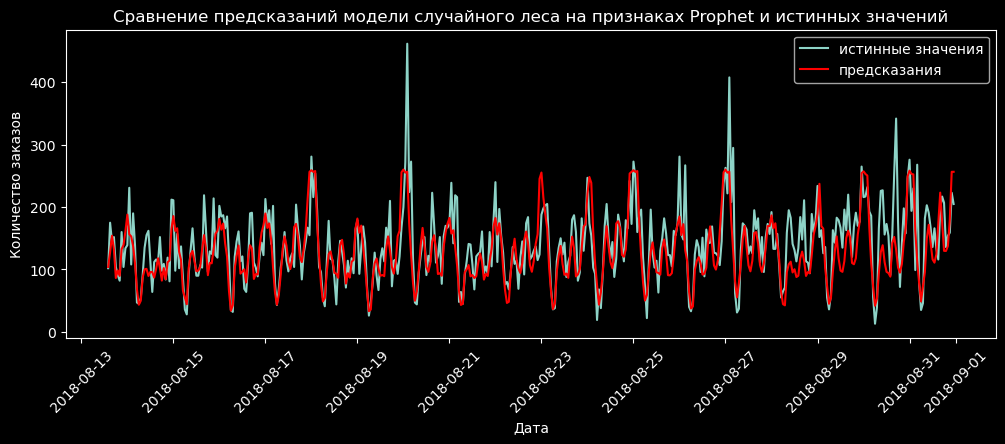

In [49]:
plt.figure(figsize=(12,4))
sns.lineplot(data=test, label='истинные значения', legend=None)
sns.lineplot(data=prophet_rf_pred, color='red', label='предсказания')
plt.title('Сравнение предсказаний модели случайного леса на признаках Prophet и истинных значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.show()

In [50]:
prophet_catb_pred = pd.Series(prophet_catb_random.predict(prophet_test),  index=test.index)
mean_squared_error(test['num_orders'], prophet_catb_pred) ** 0.5

42.39831608341331

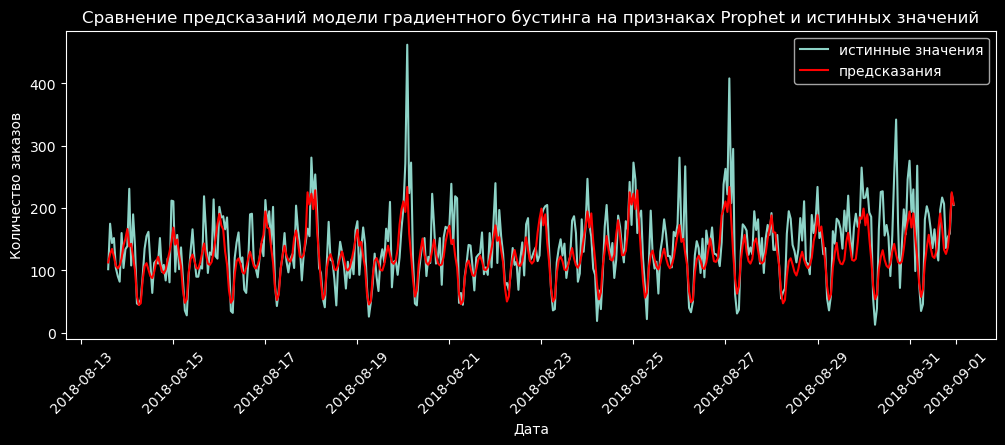

In [51]:
plt.figure(figsize=(12,4))
sns.lineplot(data=test, label='истинные значения', legend=None)
sns.lineplot(data=prophet_catb_pred, color='red', label='предсказания')
plt.title('Сравнение предсказаний модели градиентного бустинга на признаках Prophet и истинных значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.show()

### Вывод
Среди пяти проверенных моделей требованиям по качеству (RMSE < 48) соответствуют только базовая модель экспоненциального сглаживания, случайный лес и градиентный бустинг. При этом самая простая модель дает наилучшие результаты. Комбинация результатов работы модели Prophet со случайным лесом и градиентным бустингом дает небольшую прибавку в качестве. Их можно использовать вместо самостоятельной генерации признаков.

## Заключение
Исходные данные представляют собой монотонно возрастающий временной ряд. Десятиминутные интервалы в исходных данных были преобразованы в часовые с суммированием значений. Пропусков в данных нет. Ряд имеет суточную сезонность. Несмотря на восходящий тренд и увеличение дисперсии к концу рассматриваемого периода, ряд является стационарным согласно тесту Дики-Фуллера.

В качестве тестовых данных были взяты 10% в конце временного ряда. По графику заметно, что эти данные немного отличаются от предыдущих по дисперсии и среднему. В качестве моделей были выбраны: модель экспоненциального сглаживания, модель авторегрессии-скользящего среднего, модель Prophet, случайный лес и градиентный бустинг. Для моделей случайного леса и градиентного бустинга были сгенерированы дополнительные признаки: календарные, отстающие значения и скользящее среднее.

По результатам проверки моделей только три соответствуют требованию по качеству предсказаний (RMSE < 48): модель экспоненциального сглаживания, случайный лес и градиентный бустинг. Модель экспоненциального сглаживания имеет лучшие результаты (RMSE = 40). Как показал график автокорреляции, текущее значение признака сильнее всего связано с предыдущим значением и далее по убывающей с циклом в 24 часа. Модель экспоненциального сглаживания как раз использует усреднение с максимальным весом у предыдущего значения ряда. Модель SARIMAX идет заметно ниже линии истинных значений на графике. Это связано с тем, что мы приняли ряд за стационарный, а тестовые данные отличаются от тренировочных. Модель Prophet использует схожий подход к прогнозированию рядов, поэтому и результат у нее похожий.

Дополнительно были обучены модели случайного леса и градиентного бустинга на признаках, полученных в результате работы модели Prophet. Такой подход дает небольшую прибавку в качестве (~ 1 ед. RMSE для градиентного бустинга). Его можно использовать вместо генерации собственных признаков. Но этого недостаточно, чтобы превзойти самую простую модель.

Таким образом, для предсказания количества заказов такси лучше всего, среди рассмотренных моделей, подходит модель экспоненциального сглаживания с периодом 24 часа.